# Docs, sources

https://rufat.be/triangle/index.html - library used for triangulation

https://stackoverflow.com/a/50974391/10093288 - this function can be used for drawing circles through three points

https://en.wikipedia.org/wiki/Constrained_Delaunay_triangulation - Constrained Delaunay triangulation (definition)

https://rufat.be/triangle/definitions.html - Delauanay triangulation related definitions

https://en.wikipedia.org/wiki/Circumscribed_circle - properties of circumscribed circle (theory)

In [315]:
!pip install triangle
!pip install more-itertools

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import itertools as itr
import triangle as tr
import math
import scipy.linalg

### Defining input data 

In [3]:
polygonVertices = np.array([[0, 1], [1, 0], [3, 0], [0, 3], [-3, 0], [-1, 0]])
polygonHolesPoints = np.array([[0,0]])
polygonFrame = np.array([[0,1],[1,2],[2,3],[3,4],[4,5],[5,0]])

inputPolygonInfo = dict(vertices=polygonVertices, 
                        holes=polygonHolesPoints, #not reqiered parameter in our case
                        segments=polygonFrame)

# Triagulation options
**D** - Conforming Delaunay: use this switch if you want all triangles in the mesh to be Delaunay, and not just constrained Delaunay; or if you want to ensure that all Voronoi vertices lie within the triangulation.

**p** - Triangulates a Planar Straight Line Graph.


#### Styles

In [6]:
circleBorderColor = '0'
circleInnerColor = "none"

## Data

In [118]:
A = np.array([[4, 0], [0, 3]])
d = 0
f = 1

m_e = np.array([[2, 1, 1],
                [1, 2, 1],
                [1, 1, 2]])

epsilon = 10e-6

### Utility functions

In [134]:
def define_circle(p1, p2, p3, epsilon = 1.0e-6):
    """
    Returns the center and radius of the circle passing the given 3 points.
    In case the 3 points form a line, returns (None, infinity).
    """
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    
    determinant = ((p1[0] - p2[0]) * (p2[1] - p3[1]) 
                 - (p2[0] - p3[0]) * (p1[1] - p2[1]))

    if abs(determinant) < epsilon:
        return (None, np.inf)

    # Center of the circle
    centerX = (bc * (p2[1] - p3[1]) 
             - cd * (p1[1] - p2[1])) / determinant
    centerY = (cd * (p1[0] - p2[0]) 
             - bc * (p2[0] - p3[0])) / determinant

    radius = np.sqrt((centerX - p1[0]) ** 2 + (centerY - p1[1]) ** 2)
    return ((centerX, centerY), radius) 

# Check if c is between (a, b)
def is_between(a, b, c):
    crossproduct = (c[1] - a[1]) * (b[0] - a[0]) - (c[0] - a[0]) * (b[1] - a[1])

    # compare versus epsilon for floating point values, or != 0 if using integers
    if abs(crossproduct) > epsilon:
        return False

    dotproduct = (c[0] - a[0]) * (b[0] - a[0]) + (c[1] - a[1])*(b[1] - a[1])
    if dotproduct < 0:
        return False

    squaredlengthba = (b[0] - a[0])*(b[0] - a[0]) + (b[1] - a[1])*(b[1] - a[1])
    if dotproduct > squaredlengthba:
        return False

    return True

def draw_circles(circleInfo):
    vertecies = circleInfo['vertices']
    triangles = circleInfo['triangles']
    
    for triangle in triangles:
        vertex1 = vertecies[triangle[0]]
        vertex2 = vertecies[triangle[1]]
        vertex3 = vertecies[triangle[2]]
        center, radius = define_circle(vertex1, vertex2, vertex3)
        if center is not None:
            circle = plt.Circle(center, radius, clip_on = False)

            circle.set_edgecolor(circleBorderColor)
            circle.set_facecolor(circleInnerColor)

            plt.gcf().gca().add_artist(circle)
    
def get_triangulation_result(polygonInfo, options=''):
    trinagulationResult = tr.triangulate(polygonInfo, options)
    tr.compare(plt, inputPolygonInfo, trinagulationResult)
    draw_circles(trinagulationResult)
    
    triangles = trinagulationResult['triangles']
    vertices = trinagulationResult['vertices']
    
    #print(triangles)
    #print(vertices)
    
    n = (vertices).shape[0]
    #print('n', n)
    
    A_h = np.zeros((n, n))
    f_h = np.zeros((n, 1))
    
    return trinagulationResult, A_h, f_h

def find_boundary_points(vertices, i, j, m, boundary = set()):
    for q in range(0, polygonVertices.shape[0]):
        boundary.add(tuple(polygonVertices[q]))

        for k in range(0, polygonVertices.shape[0]):
            for ind in [i, j, m]:
                if(k != q and 
                   (polygonVertices[q] != list(vertices[ind])).all() and 
                   (polygonVertices[k] != list(vertices[ind])).all() and 
                   is_between(polygonVertices[q], polygonVertices[k], list(vertices[ind]))):
                    boundary.add(tuple(vertices[ind]))

    for q in range(0, len(boundary)):
        for k in range(0, len(boundary)):
            for ind in [i, j, m]:
                if(k != q and 
                   (list(boundary)[q] != list(vertices[ind])) and 
                   (list(boundary)[k] != list(vertices[ind])) and 
                   is_between(list(boundary)[q], list(boundary)[k], list(vertices[ind]))):
                    boundary.add(tuple(vertices[ind]))
                    
    return sorted(boundary)
                        
def find_U(triangulationResult, A_h, f_h):
    triangles = triangulationResult['triangles']
    vertices = triangulationResult['vertices']
    
    boundarySet = set()
    
    p = 0
    for triangle in triangles:
        if(p + 3 == f_h.shape[0]):
            break;
            
        i = triangle[0]
        j = triangle[1]
        m = triangle[2]
    
        boundary = find_boundary_points(vertices, i, j, m, boundarySet)
        
        a = np.array([[1, vertices[i, 0], vertices[i, 1]], 
                      [1, vertices[j, 0], vertices[j, 1]],
                      [1, vertices[m, 0], vertices[m, 1]]])
        delta = np.linalg.det(a)

        a_i = vertices[j, 0] * vertices[m, 1] - vertices[j, 1] * vertices[m, 0]
        
        b_i = vertices[j, 1] - vertices[m, 1]
        b_j = vertices[m, 1] - vertices[i, 1]
        b_m = vertices[i, 1] - vertices[j, 1]
        
        c_i = vertices[m, 0] - vertices[j, 0]
        c_j = vertices[i, 0] - vertices[m, 0]
        c_m = vertices[j, 0] - vertices[i, 0]

        k = np.array([[A[0, 0] * b_i**2 + A[1, 1] * c_i**2, 
                       A[0, 0] * b_i * b_j + A[1, 1] * c_i * c_j, 
                       A[0, 0] * b_i * b_m + A[1, 1] * c_i * c_m],
                      
                      [A[0, 0] * b_i * b_j + A[1, 1] * c_i * c_j,
                       A[0, 0] * b_i**2 + A[1, 1] * c_i**2,
                       A[0, 0] * b_j * b_m + A[1, 1] * c_j * c_m],
                      
                      [A[0, 0] * b_i * b_m + A[1, 1] * c_i * c_m, 
                       A[0, 0] * b_j * b_m + A[1, 1] * c_j * c_m,
                       A[0, 0] * b_i**2 + A[1, 1] * c_i**2]])
        
        K_e = k / (2 * delta)
        M_e = d * delta * m_e / 24
        Q_e = delta * f * np.array([f, f, f])[np.newaxis].T / 6
        
        #A_h[p:p + 3, p:p + 3] = A_h[p:p + 3, p:p + 3] + K_e
        #f_h[p:p + 3] = f_h[p:p + 3] + Q_e
        
        A_h[i, i] = A_h[i, i] + K_e[0, 0] + M_e[0, 0]
        A_h[i, j] = A_h[i, j] + K_e[0, 1] + M_e[0, 1]
        A_h[i, m] = A_h[i, m] + K_e[0, 2] + M_e[0, 2]
        
        A_h[j, i] = A_h[j, i] + K_e[1, 0] + M_e[1, 0]
        A_h[j, j] = A_h[j, j] + K_e[1, 1] + M_e[1, 1]
        A_h[j, m] = A_h[j, m] + K_e[1, 2] + M_e[1, 2]
        
        A_h[m, i] = A_h[m, i] + K_e[2, 0] + M_e[2, 0]
        A_h[m, j] = A_h[m, j] + K_e[2, 1] + M_e[2, 1]
        A_h[m, m] = A_h[m, m] + K_e[2, 2] + M_e[2, 2]
        
        f_h[i] = f_h[i] + Q_e[0]
        f_h[j] = f_h[j] + Q_e[1]
        f_h[m] = f_h[m] + Q_e[2]
        
        p = p + 1
        
    #print('A: ', A_h)
    #print('f: ', f_h
    
    print('Boundary: ', boundary, '\n')
    
    U = np.linalg.solve(A_h, f_h)
    return U

## Triangulating and showing results

Boundary:  [(-3, 0), (-2.2928932188134525, 0.7071067811865475), (-2.0, 0.0), (-1.5, 1.5), (-1, 0), (-0.75, 2.25), (-0.5, 0.5), (0, 1), (0, 3), (0.5, 0.5), (0.7928932188134522, 2.207106781186548), (1, 0), (1.5857864376269046, 1.4142135623730954), (2.0, 0.0), (2.2928932188134525, 0.7071067811865475), (3, 0)] 

U:  [[ 9.46813121]
 [10.30771574]
 [ 4.39515784]
 [15.71817293]
 [ 4.54615364]
 [ 6.42175753]
 [ 9.49623826]
 [ 5.44791234]
 [ 6.07108379]
 [ 9.80710236]
 [ 6.46760015]
 [ 6.91490372]
 [ 8.48070186]
 [ 5.65320415]
 [ 6.46178236]
 [ 6.41168976]
 [17.32269632]
 [14.494362  ]
 [10.92207322]
 [ 6.13673719]
 [19.85374004]]


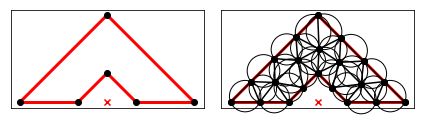

In [135]:
(v, A_h, f_h) = get_triangulation_result(inputPolygonInfo, 'Dpa0.5')

U = find_U(v, A_h, f_h)
print('U: ', U)

Boundary:  [(-3, 0), (-1.5, 1.5), (-1, 0), (0, 1), (0, 3), (1, 0), (1.5857864376269046, 1.4142135623730954), (3, 0)] 

U:  [[3.91552252]
 [3.84752638]
 [2.57937381]
 [1.93897602]
 [2.07933719]
 [3.14480979]
 [3.47866861]
 [2.84069821]]


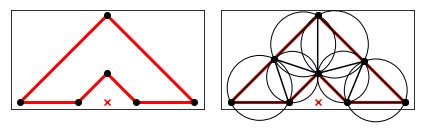

In [136]:
(v, A_h, f_h) = get_triangulation_result(inputPolygonInfo, 'Dpa')

U = find_U(v, A_h, f_h)
print('U: ', U)